# **Analysing the MOS data**

---

### Table of Contents

* [1. Generating the events files](#event_files)
* [2. Creating an Image](#Image)
* [3. Creating a Lightcurve](#lightcurve)
    * [3.1 Standard Filters](#filters)
    * [3.2 Light Curve](#lightcurve)
    * [3.3 Trimming the Data](#trim)
* [ 4. Checking for Pile Up](#pileup)
    * [4.1 MOS1](#mos1)
    * [4.2 MOS2](#mos2)
* [5. Preparing the Spectrum](#spec_prep)
* [6. XSPEC](#xspec)

### 1. Generating the Events Files<a class="anchor" id="events_files"></a>

To analyse the MOS data, the imaging events files first needed to be created. First the ODF location needed to be established

In [ ]:
export SAS_ODF='/data/cluster4/jamie_and_jeton/work_dir/0301_0029740101_data/0301_0029740101_SCX00000SUM.SAS'

In [ ]:
emproc

Got errors as it couldn't find the ccf file. I re-ran `cifbuild` in the working directory and reset where the ccf.cif file was located by running the command:

In [ ]:
export SAS_CCF='/data/cluster4/jamie_and_jeton/work_dir/0301_0029740101_data/ccf.cif'

In [ ]:
emproc 

All the imaging and bad events files were created, there are a lot of bad imaging events files, I am not sure if this is an error or just how the data is. The imaging events files for the two cameras were renamed:

In [ ]:
mv 0301_0029740101_EMOS1_S001_ImagingEvts.ds mos1.fits

In [ ]:
mv 0301_0029740101_EMOS2_S002_ImagingEvts.ds mos2.fits

### 2. Creating an image<a class="anchor" id="image"></a>

In [ ]:
 evselect table=mos1.fits withimageset=yes imageset=mos1_image.fits xcolumn=X ycolumn=Y imagebinning=imageSize ximagesize=600 yimagesize=600

In [ ]:
ds9 mos1_image.fits &

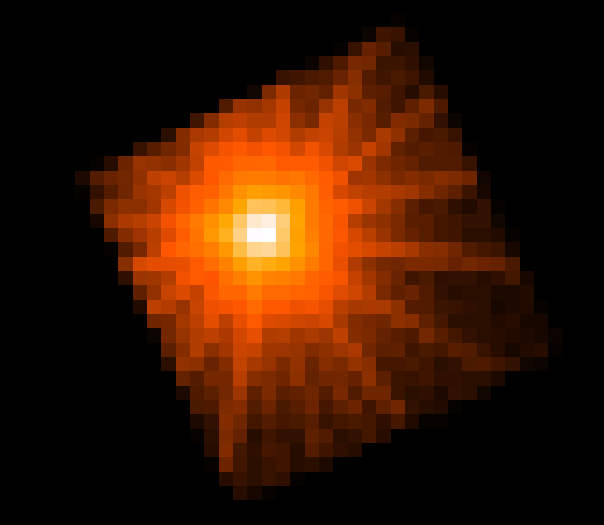

In [ ]:
evselect table=mos2.fits withimageset=yes imageset=mos2_image.fits xcolumn=X ycolumn=Y imagebinning=imageSize ximagesize=600 yimagesize=600

In [ ]:
ds9 mos2_image.fits &

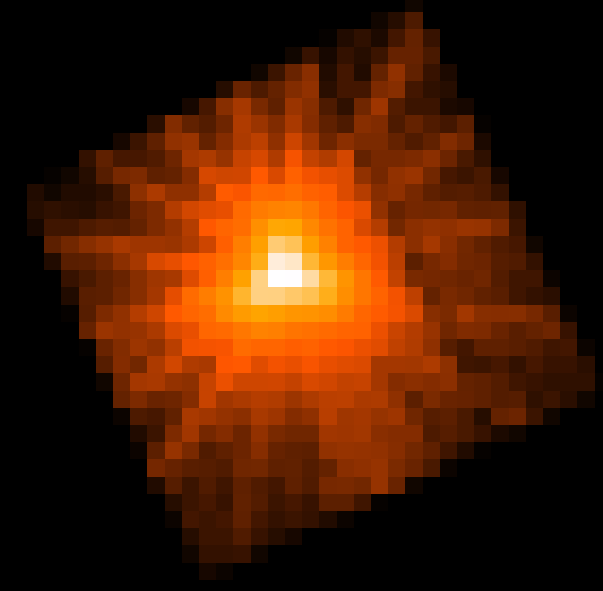

### 3. Creating a Lightcurve<a class="anchor" id="lightcurve"></a>

#### 3.1 Standard filters<a class="anchor" id="filters"></a>

In [ ]:
evselect table=mos1.fits withfilteredset=yes expression='(PATTERN <= 12)&&(PI in [200:12000])' filteredset=mos1_filtered.fits filtertype=expression keepfilteroutput=yes updateexposure=yes filterexposure=yes

In [ ]:
evselect table=mos2.fits withfilteredset=yes expression='(PATTERN <= 12)&&(PI in [200:12000])' filteredset=mos2_filtered.fits filtertype=expression keepfilteroutput=yes updateexposure=yes filterexposure=yes

#### 3.2 Light Curve<a class="anchor" id="lightcurve"></a>

In [ ]:
evselect table=mos1_filtered.fits withrateset=yes rateset=mos1_lightcurve.fits maketimecolumn=yes timecolumn=TIME timebinsize=100 makeratecolumn=yes

In [ ]:
dsplot table=mos1_lightcurve.fits x=TIME y=RATE

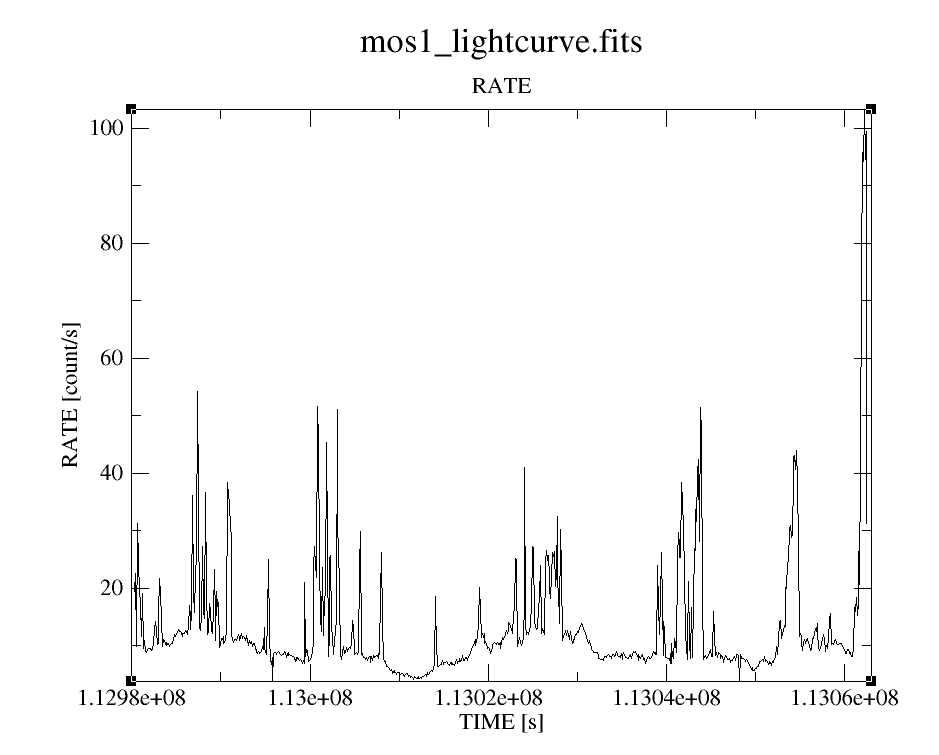

In [ ]:
evselect table=mos2_filtered.fits withrateset=yes rateset=mos2_lightcurve.fits maketimecolumn=yes timecolumn=TIME timebinsize=100 makeratecolumn=yes

In [ ]:
dsplot table=mos2_lightcurve.fits x=TIME y=RATE

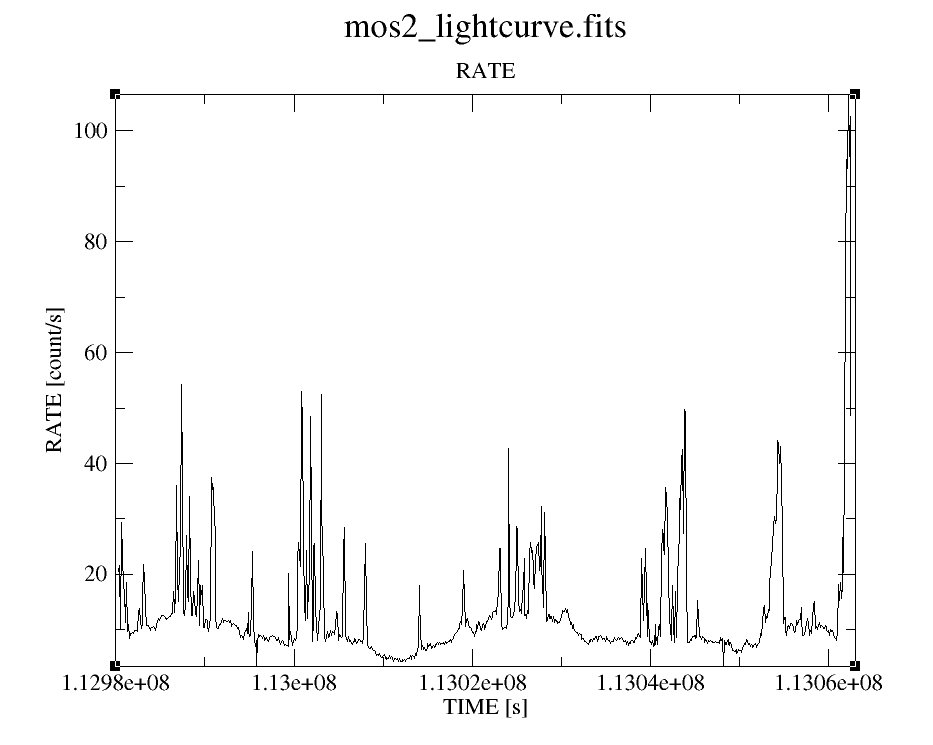

#### 3.3 Trimming the data<a class="anchor" id="trim"></a>

There is a flare in both the cameras after 1.1306e8 that will need to be removed

In [ ]:
> mos1_time.txt

In [ ]:
nano mos1_time.txt

In [ ]:
" 0 1.1306e8 +"

In [ ]:
 gtibuild file=mos1_time.txt table=gti.fits

In [ ]:
evselect table=mos1_filtered.fits withfilteredset=yes expression='GTI(gti.fits,TIME)' filteredset=mos1_clean.fits filtertype=expression filterexposure=yes

In [ ]:
evselect table=mos1_clean.fits withrateset=yes rateset=mos1_clean_lightcurve.fits maketimecolumn=yes timecolumn=TIME timebinsize=100 makeratecolumn=yes

In [ ]:
dsplot table=mos1_clean_lightcurve.fits x=TIME y=RATE &

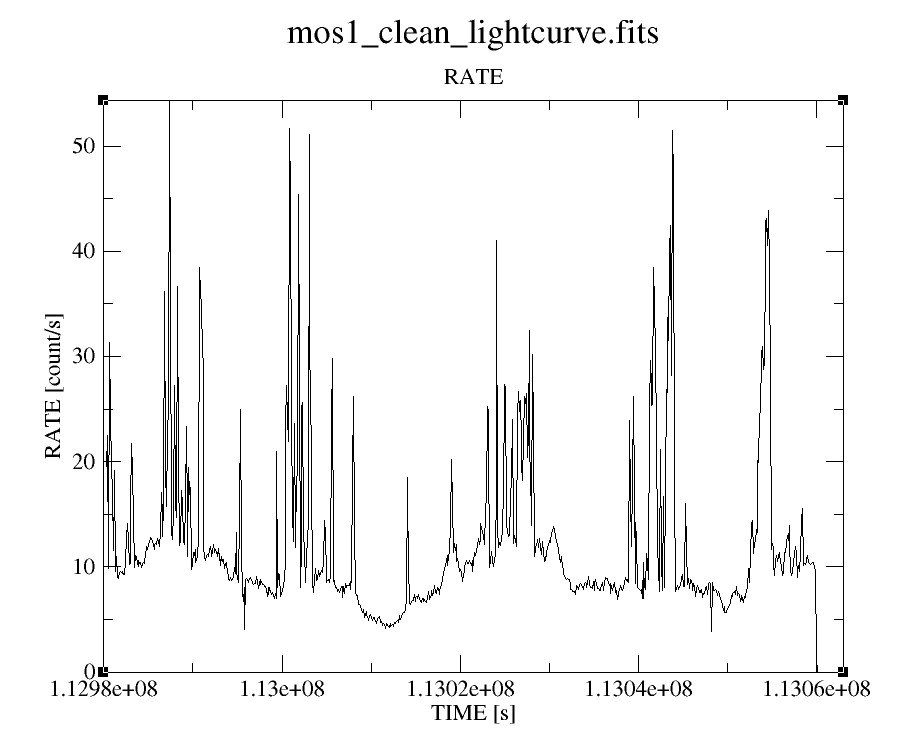

In [ ]:
evselect table=mos2_filtered.fits withfilteredset=yes expression='GTI(gti.fits,TIME)' filteredset=mos2_clean.fits filtertype=expression filterexposure=yes

In [ ]:
evselect table=mos2_clean.fits withrateset=yes rateset=mos2_clean_lightcurve.fits maketimecolumn=yes timecolumn=TIME timebinsize=100 makeratecolumn=yes

In [ ]:
dsplot table=mos2_clean_lightcurve.fits x=TIME y=RATE &

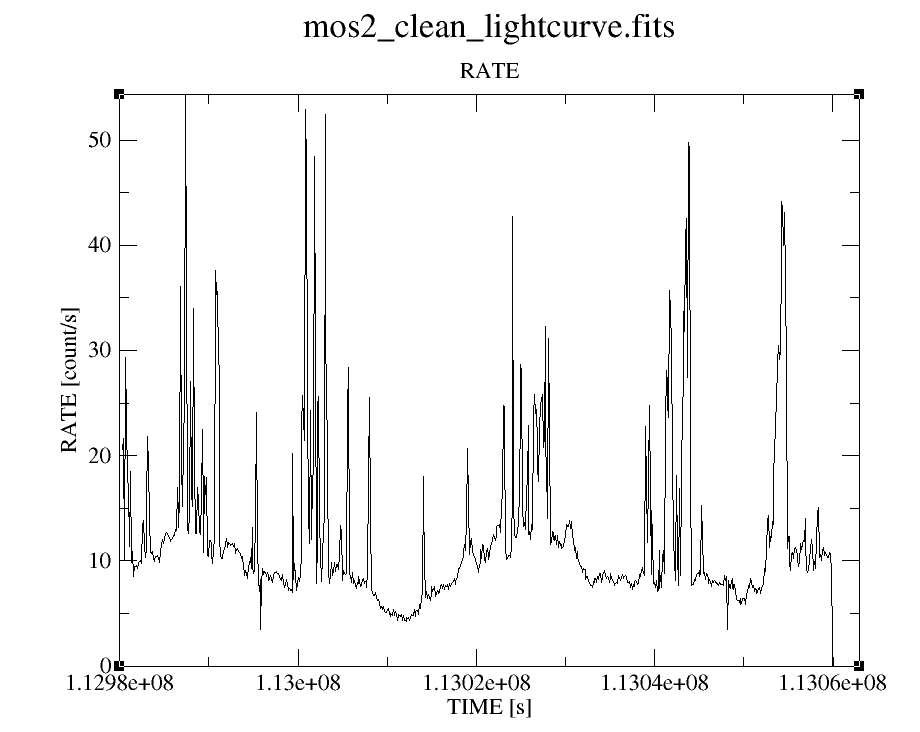

With the flares at the end of the observations removed, the overall behaviour of the observation can be more clearly seen, although there are still many sharp increases in count rates that may be to do with additional background flares. An analysis of the background lightcurve is needed to detemrine this.

### 4. Checking for Pileup<a class="anchor" id="pileup"></a>

First the source and background regions need to be determined.

#### 4.1 MOS1<a class="anchor" id="mos1"></a>

In [ ]:
ds9 mos1_filtered.fits &

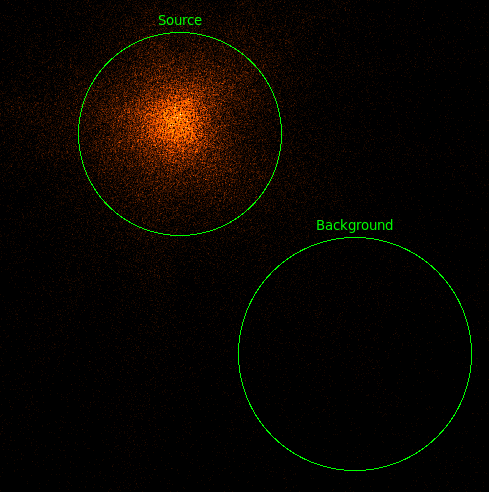

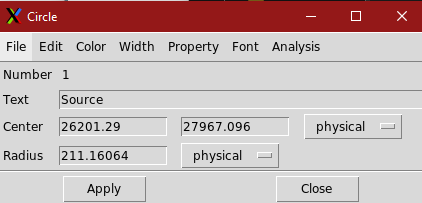

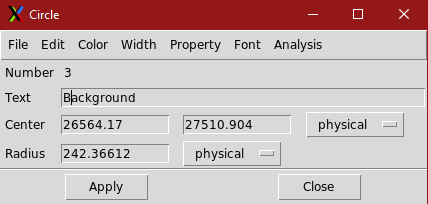

Extracting the source spectrum

In [ ]:
evselect table=mos1_clean.fits energycolumn='PI' withfilteredset=yes filteredset='mos1_filt.fits' keepfilteroutput=yes filtertype=expression withspectrumset=yes spectrumset=mos1_source_spec.fits spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression='((X,Y) IN circle(26201,27967,211.16))'

Extracting the background spectrum

In [ ]:
evselect table=mos1_clean.fits withfilteredset=yes filteredset=mos1_bkg_filt.fits keepfilteroutput=yes filtertype=expression withspectrumset=yes spectrumset=mos1_backg_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression='((X,Y) IN circle(26564,27511,242))'

In [ ]:
epatplot set=mos1_filt.fits plotfile=mos1_pileup.ps useplotfile=yes withbackgroundset=yes backgroundset=mos1_bkg_filt.fits

In [ ]:
gv mos1_pileup.ps &

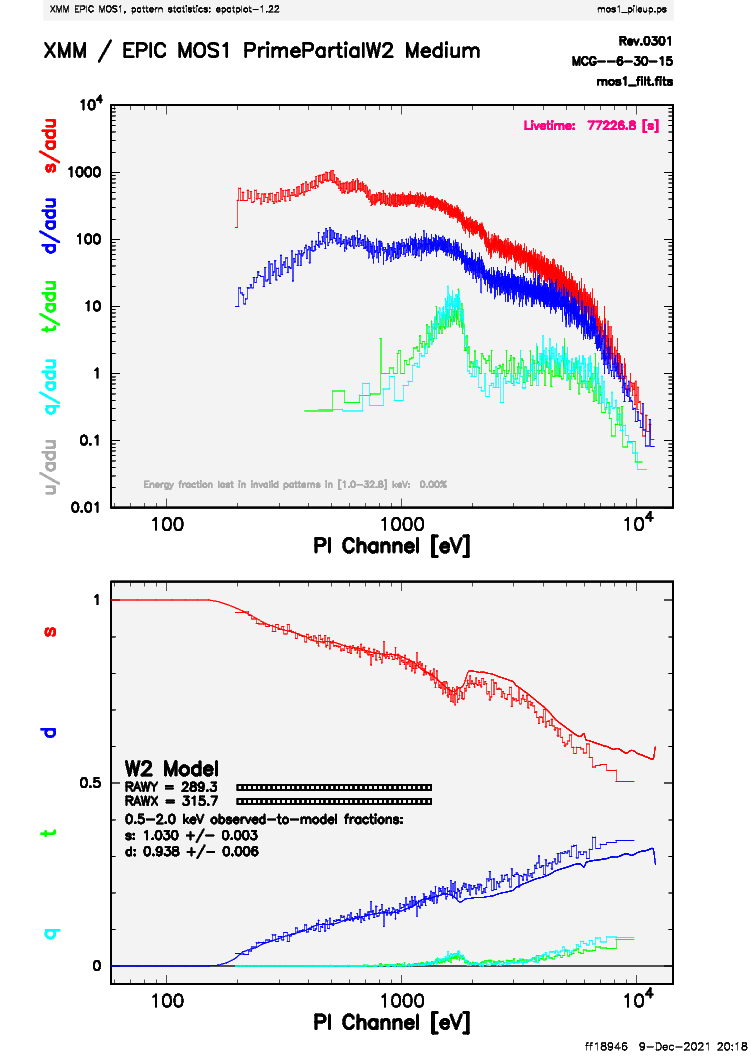

#### 4.2 MOS2<a class="anchor" id="mos2"></a>

In [ ]:
ds9 mos2_clean.fits &

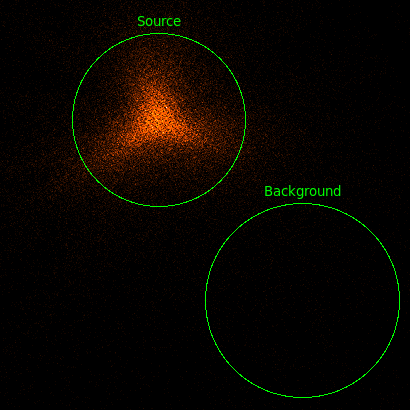

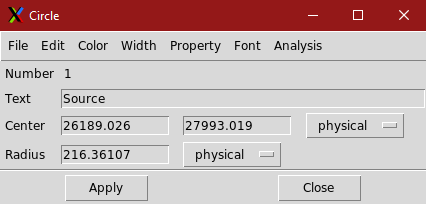

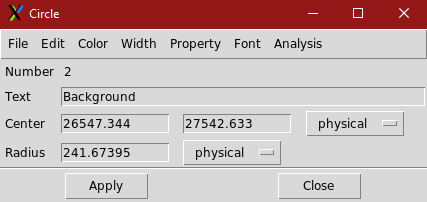

Extracting the source spectrum

In [ ]:
evselect table=mos2_clean.fits energycolumn='PI' withfilteredset=yes filteredset='mos2_filt.fits' keepfilteroutput=yes filtertype=expression withspectrumset=yes spectrumset=mos2_source_spec.fits spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression='((X,Y) IN circle(26189,27993,216))'

In [ ]:
evselect table=mos2_clean.fits withfilteredset=yes filteredset=mos2_bkg_filt.fits keepfilteroutput=yes filtertype=expression withspectrumset=yes spectrumset=mos1_backg_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression='((X,Y) IN circle(26547,27543,242))'

In [ ]:
epatplot set=mos2_filt.fits plotfile=mos2_pileup.ps useplotfile=yes withbackgroundset=yes backgroundset=mos2_bkg_filt.fits

In [ ]:
gv mos2_pileup.ps &

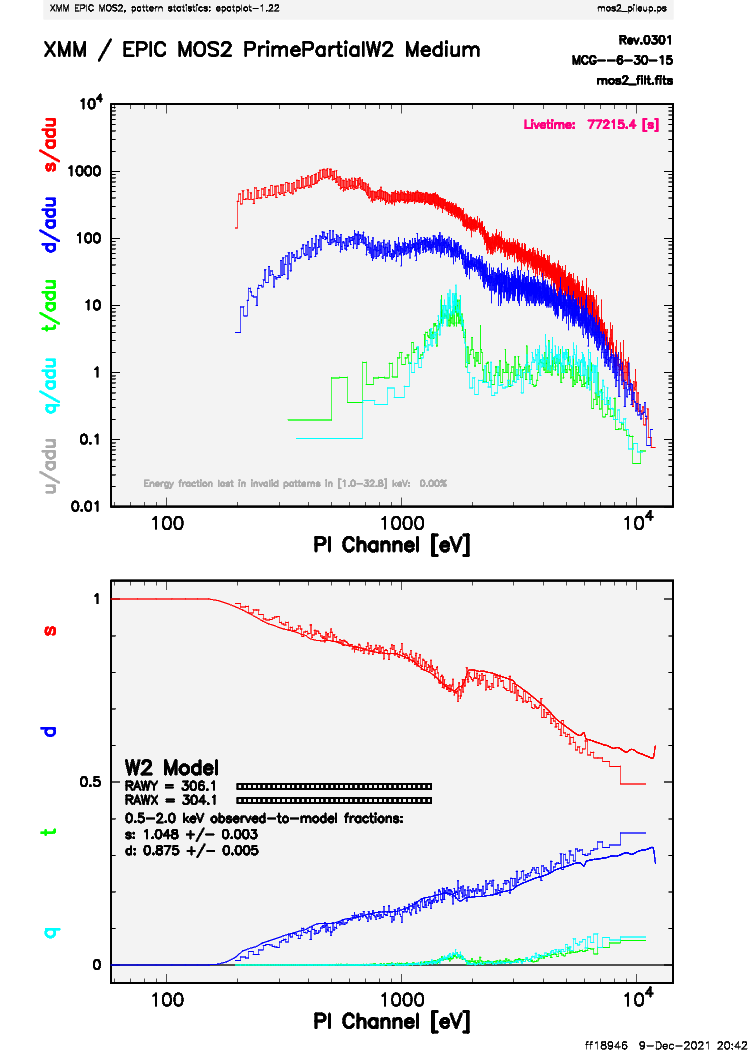

### 5. Preparing the Spectrum<a class="anchor" id="spec_prep"></a>

In [ ]:
rmfgen rmfset=mos1_rmf.fits spectrumset=mos1_source_spec.fits

In [ ]:
arfgen arfset=mos1_arf.fits spectrumset=mos1_source_spec.fits withrmfset=yes rmfset=mos1_rmf.fits withbadpixcorr=yes badpixlocation=mos1_clean.fits setbackscale=yes

In [ ]:
specgroup spectrumset=mos1_source_spec.fits mincounts=25 oversample=3 rmfset=mos1_rmf.fits arfset=mos1_arf.fits backgndset=mos1_backg_spec.fits groupedset=mos1_spectrum_grp.fits

### 6. XSPEC<a class="anchor" id="xspec"></a>